In [2]:
import torch
import timm
from torch.utils.data import DataLoader
from torchvision.models import swin_v2_t, Swin_V2_T_Weights
from torchvision import transforms
import torch.nn as nn

from ouhands_loader import OuhandsDS

model = timm.create_model(
    'vit_base_patch16_dinov3.lvd1689m',
    pretrained=True,
)

# Get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**data_config, is_training=False)

batch_size = 32
num_workers = 4
use_bbox = False

train_ds = OuhandsDS(split='train',
                     transform=transform,
                     use_bounding_box=use_bbox,
                     crop_to_bbox=use_bbox)
val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=use_bbox,
                   crop_to_bbox=use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=use_bbox,
                    crop_to_bbox=use_bbox)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True
                          ,  num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False
                        , num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False
                          , num_workers=num_workers, pin_memory=True)

device = (
    torch.device("cuda") if torch.cuda.is_available()
    else torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Using device: cuda


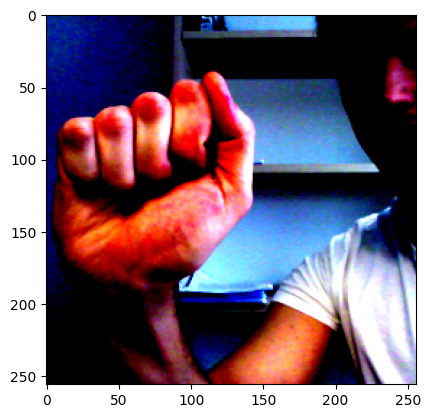

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_ds[0][0].permute(1, 2, 0).numpy())

In [4]:
""" DINO model architecture """
model.blocks

ModuleList(
  (0-11): 12 x EvaBlock(
    (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): EvaAttention(
      (qkv): Linear(in_features=768, out_features=2304, bias=False)
      (q_norm): Identity()
      (k_norm): Identity()
      (attn_drop): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (proj): Linear(in_features=768, out_features=768, bias=True)
      (proj_drop): Dropout(p=0.0, inplace=False)
    )
    (drop_path1): Identity()
    (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Mlp(
      (fc1): Linear(in_features=768, out_features=3072, bias=True)
      (act): GELU(approximate='none')
      (drop1): Dropout(p=0.0, inplace=False)
      (norm): Identity()
      (fc2): Linear(in_features=3072, out_features=768, bias=True)
      (drop2): Dropout(p=0.0, inplace=False)
    )
    (drop_path2): Identity()
  )
)

In [6]:
"""Utility functions"""
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch.optim import AdamW
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import timm

from sklearn.metrics import precision_score, recall_score, f1_score


# Optimizer / Scheduler
def param_groups(model, weight_decay=0.05):
    """ Add weight decay on non-bias or non-LayerNorm, BatchNorm weights"""
    decay, no_decay = [], []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or n.endswith(".bias"):  # bias or LayerNorm/BatchNorm weights
            no_decay.append(p)
        else:
            decay.append(p)
    return [
        {"params": decay, "weight_decay": weight_decay},
        {"params": no_decay, "weight_decay": 0.0},
    ]


# Training / Evaluation loops
def train_one_epoch(model, loader, optimizer, scaler, epoch, max_norm=1.0):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    pbar = tqdm(loader, desc=f"Train {epoch}", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision training
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        if max_norm is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()

        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=running_correct/total)

    return running_loss / total, running_correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        with autocast('cuda'):
            logits = model(imgs)
            loss = criterion(logits, labels)
        preds = logits.argmax(1)
        running_loss += loss.item() * imgs.size(0)
        running_correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, running_correct / total

def eval_on_test(model, test_loader):
  # Evaluation on the test set
  model.eval()
  total_loss = 0.0
  total_correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for imgs, labels in test_loader:
          imgs, labels = imgs.to(device), labels.to(device)
          logits = model(imgs)
          preds = logits.argmax(1)

          total_correct += (preds == labels).sum().item()
          total += imgs.size(0)

          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  accuracy = total_correct / total
  precision = precision_score(all_labels, all_preds, average='macro')
  recall = recall_score(all_labels, all_preds, average='macro')
  f1 = f1_score(all_labels, all_preds, average='macro')

  print(f"Test accuracy: {accuracy:.4f}")
  print(f"Precision (macro): {precision:.4f}")
  print(f"Recall (macro): {recall:.4f}")
  print(f"F1-score (macro): {f1:.4f}")



In [7]:
"""DINO - unfreeze last K blocks"""

num_classes = 10

model = timm.create_model(
    'vit_base_patch16_dinov3.lvd1689m',
    pretrained=True,
)

# Replace classifier head
model.reset_classifier(num_classes=num_classes)
model = model.to(device)

# Unfreeze the last K blocks
K = 3
for p in model.parameters():
    p.requires_grad = False

for block in model.blocks[-K:]:
    for p in block.parameters():
        p.requires_grad = True

for p in model.get_classifier().parameters():
    p.requires_grad = True

lr = 5e-4
optimizer = AdamW(param_groups(model), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

# LR scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Gradient Scaling
scaler = GradScaler()

# Training
epochs = 10
best_acc = 0.0
best_state = None

print(f"DINO Fine-tune with last {K} blocks unfrozen")
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, scaler, epoch)
    val_loss, val_acc = evaluate(model, test_loader)
    scheduler.step()

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

DINO Fine-tune with last 3 blocks unfrozen


Epoch 01: train_loss=0.4511 train_acc=0.8505 | val_loss=0.1090 val_acc=0.9690


Epoch 02: train_loss=0.0289 train_acc=0.9930 | val_loss=0.1237 val_acc=0.9730


Epoch 03: train_loss=0.0177 train_acc=0.9935 | val_loss=0.1773 val_acc=0.9520


Epoch 04: train_loss=0.0133 train_acc=0.9975 | val_loss=0.1675 val_acc=0.9570


Epoch 05: train_loss=0.0074 train_acc=0.9995 | val_loss=0.1998 val_acc=0.9600


Epoch 06: train_loss=0.0003 train_acc=1.0000 | val_loss=0.1410 val_acc=0.9700


Epoch 07: train_loss=0.0001 train_acc=1.0000 | val_loss=0.1484 val_acc=0.9680


Epoch 08: train_loss=0.0001 train_acc=1.0000 | val_loss=0.1529 val_acc=0.9680


Epoch 09: train_loss=0.0001 train_acc=1.0000 | val_loss=0.1559 val_acc=0.9660


Epoch 10: train_loss=0.0001 train_acc=1.0000 | val_loss=0.1577 val_acc=0.9660


In [14]:
# Save best checkpoint
if best_state is not None:
    torch.save(best_state, "./checkpoints/vit_dinov3_best.pt")
    print(f"Saved best model with val_acc={best_acc:.4f} to vit_dinov3_best.pt")

Saved best model with val_acc=0.9740 to vit_dinov3_best.pt


In [9]:
"""DINO - last 3 block unfrozen Results"""

print("DINO - last 3 unfrozen - 10 epochs")
eval_on_test(model, test_loader)

DINO - last 3 unfrozen - 10 epochs
Test accuracy: 0.9660
Precision (macro): 0.9678
Recall (macro): 0.9660
F1-score (macro): 0.9663


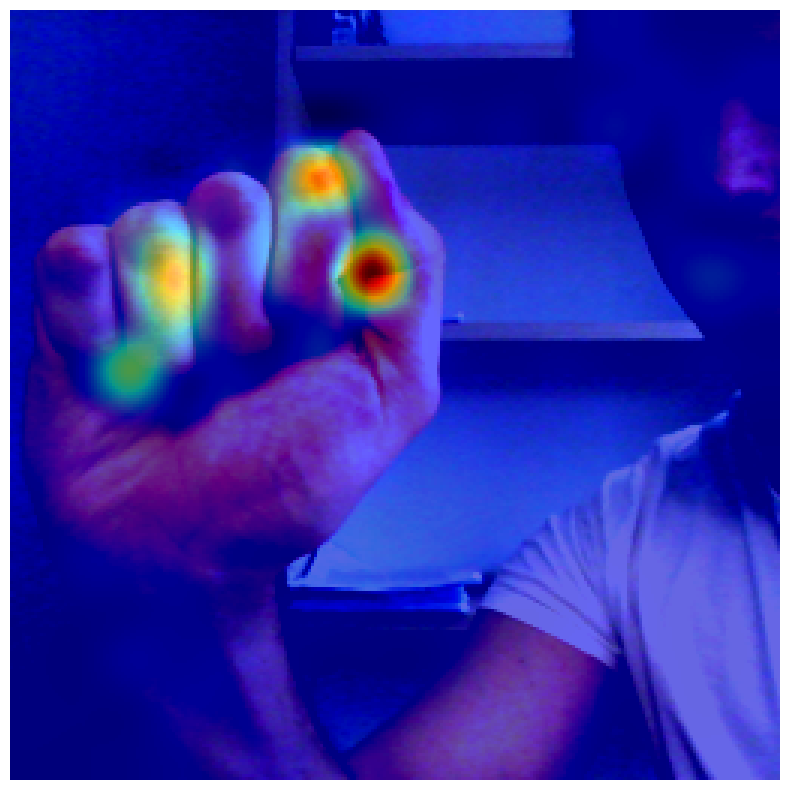

In [10]:
"""Visualize attention map"""

import math
import matplotlib.pyplot as plt
import torch.nn.functional as F

img = train_ds[0][0] # Random data in the dataset [3, H, W]
x = img.unsqueeze(0) # [1, 3, H, W]
x = x.to(device)

IMG_SIZE = x.shape[-1] # H = W
patch = model.patch_embed.patch_size[0]

# ---- Run through all but the last block; capture tokens pre-last-attn ----
with torch.no_grad():
    # Patch embed + pos embed (+ optional pre-norm) like timm's forward_features
    x_tok = model.patch_embed(x)              # [B, Np, C]   (no cls yet)
    x_tok = model._pos_embed(x_tok)           # adds cls token & pos emb if present

    # Check if x_tok is a tuple and extract the tensor if it is
    if isinstance(x_tok, tuple):
        x_tok = x_tok[0]
    if hasattr(model, "pos_drop"):
        x_tok = model.pos_drop(x_tok)
    if hasattr(model, "norm_pre") and model.norm_pre is not None:
        x_tok = model.norm_pre(x_tok)

    # Forward through blocks except the last
    for blk in model.blocks[:-1]:
        x_tok = blk(x_tok)

    last_blk = model.blocks[-1]

    # ---- Compute attention of the last block explicitly ----
    # In a ViT block: y = x + Attn(LN1(x)), so the attention takes LN1(x) as input
    x_norm = last_blk.norm1(x_tok)

    # QKV projection
    B, N, C = x_norm.shape
    qkv = last_blk.attn.qkv(x_norm)  # [B, N, 3*C]
    num_heads = last_blk.attn.num_heads
    head_dim = C // num_heads
    scale = 1.0 / math.sqrt(head_dim)

    qkv = qkv.reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)   # [3,B,H,N,D]
    q, k, v = qkv[0], qkv[1], qkv[2]                                         # each [B,H,N,D]

    attn = (q * scale) @ k.transpose(-2, -1)                                 # [B,H,N,N]
    attn = attn.softmax(dim=-1)                                              # prob over keys

    # ---- Reshape to patch grid and upsample to image size ----
    H_p = W_p = IMG_SIZE // patch                 # e.g., 32x32 for 512 input
    Np = H_p * W_p

    # ---- CLS-to-patches attention map (average over heads) ----
    # CLS token is at index 0; keep only patch tokens by slicing from (N - Np) onwards
    attn_cls = attn[:, :, 0, (N - Np):]                                      # [B, H, Np]
    attn_map = attn_cls.max(1).values

    # robust: patches are the *last* Np tokens in the sequence
    attn_map = attn_map.reshape(B, 1, H_p, W_p) # [B,1,H_p,W_p]
    attn_map = F.interpolate(attn_map, size=(IMG_SIZE, IMG_SIZE), mode="bicubic", align_corners=False)
    attn_map = attn_map[0,0] # [H, W]
    # Normalize for visualization
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)

# ---- Plot overlay ----
plt.figure(figsize=(8,8))
img_np = x[0].cpu().permute(1, 2, 0).numpy()
plt.imshow(img_np)
plt.imshow(attn_map.cpu(), cmap='jet', alpha=0.6)
plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
"""Same ViT model supervised pretrained"""

vit_model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Replace classifier head
vit_model.reset_classifier(num_classes=num_classes)
vit_model = vit_model.to(device)

# Unfreeze the last K blocks
K = 3
for p in vit_model.parameters():
    p.requires_grad = False

for block in vit_model.blocks[-K:]:
    for p in block.parameters():
        p.requires_grad = True

for p in vit_model.get_classifier().parameters():
    p.requires_grad = True

data_config = timm.data.resolve_model_data_config(vit_model)
transform = timm.data.create_transform(**data_config, is_training=False)

batch_size = 32
num_workers = 4
use_bbox = False

train_ds = OuhandsDS(split='train',
                     transform=transform,
                     use_bounding_box=use_bbox,
                     crop_to_bbox=use_bbox)
val_ds = OuhandsDS(split='validation',
                   transform=transform,
                   use_bounding_box=use_bbox,
                   crop_to_bbox=use_bbox)
test_ds = OuhandsDS(split='test',
                    transform=transform,
                    use_bounding_box=use_bbox,
                    crop_to_bbox=use_bbox)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True
                          ,  num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False
                        , num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False
                          , num_workers=num_workers, pin_memory=True)


# Same everything
lr = 5e-4
optimizer = AdamW(param_groups(vit_model), lr=lr, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()

# LR scheduling
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Gradient Scaling
scaler = GradScaler()

# Training
epochs = 10
best_acc = 0.0
best_state = None

print(f'Training ViT model with the same setting')
for epoch in range(1, epochs + 1):
    train_loss, train_acc = train_one_epoch(vit_model, train_loader, optimizer, scaler, epoch)
    val_loss, val_acc = evaluate(vit_model, test_loader)
    scheduler.step()

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Training ViT model with the same setting


Epoch 01: train_loss=1.2472 train_acc=0.6060 | val_loss=0.7690 val_acc=0.7590


Epoch 02: train_loss=0.2826 train_acc=0.9055 | val_loss=0.8789 val_acc=0.8020


Epoch 03: train_loss=0.1826 train_acc=0.9480 | val_loss=0.7665 val_acc=0.8200


Epoch 04: train_loss=0.1211 train_acc=0.9630 | val_loss=0.9866 val_acc=0.8020


Epoch 05: train_loss=0.1013 train_acc=0.9720 | val_loss=0.8638 val_acc=0.8360


Epoch 06: train_loss=0.0522 train_acc=0.9890 | val_loss=1.4807 val_acc=0.7690


Epoch 07: train_loss=0.0675 train_acc=0.9800 | val_loss=1.3287 val_acc=0.8150


Epoch 08: train_loss=0.0358 train_acc=0.9900 | val_loss=1.1175 val_acc=0.8180


Epoch 09: train_loss=0.0512 train_acc=0.9870 | val_loss=0.7834 val_acc=0.8600


Epoch 10: train_loss=0.0218 train_acc=0.9970 | val_loss=1.0468 val_acc=0.8400


In [12]:
print("vit_base_patch16_224")
eval_on_test(vit_model, test_loader)

vit_base_patch16_224
Test accuracy: 0.8400
Precision (macro): 0.8664
Recall (macro): 0.8400
F1-score (macro): 0.8397


In [13]:
! pip install thop

In [16]:
"""Number of parameters and flops calculation"""

from thop import profile

dummy_input = next(iter(test_loader))[0]
dummy_input = dummy_input.to(device)
flops, params = profile(model, inputs=(dummy_input,))

print("vit_base_patch16_dinov3.lvd1689m")
print(f"FLOPs: {flops / 1e9:.2f}G")
print(f"Params: {params / 1e6:.2f}M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
vit_base_patch16_dinov3.lvd1689m
FLOPs: 550.00G
Params: 85.59M


In [15]:
flops, params = profile(vit_model, inputs=(dummy_input,))

print("vit_base_patch16_224")
print(f"FLOPs: {flops / 1e9:.2f}G")
print(f"Params: {params / 1e6:.2f}M")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
vit_base_patch16_224
FLOPs: 539.13G
Params: 85.62M
